In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from basic_unet import UNet
from dataset import load_dataset
from plot_utils import plot_image_row
from hausdorff_distance_masks import HausdorffDistanceMasks

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset(batch_size=1, directory='data/processed_contour/')
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/contour_1_0200.pth')
model.load_state_dict(state_dict)
model = model.to(device)

In [3]:
it = iter(test_loader)
next(it)
sample = next(it)
segment = sample['segment']
segment = segment.squeeze()

image = sample['input']
image = image.to(device)

output = model(image)
output = output.detach().cpu().squeeze().numpy()

In [4]:
hdm = HausdorffDistanceMasks(240, 240)
hdm.generate_masks(circle_size=20, offset=5, normalize=True)
distances = hdm.evaluate(image, segment, model, device)

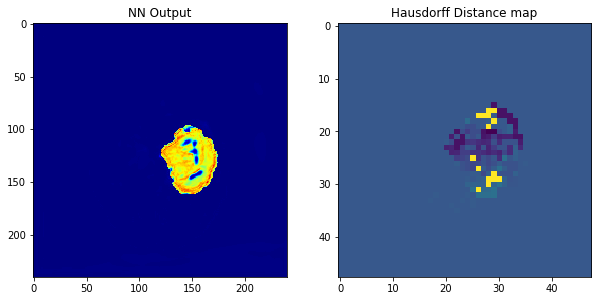

In [5]:
plot_image_row(
    [output, distances],
    color_maps=['jet', 'viridis'],
    labels=['NN Output', 'Hausdorff Distance map']
)

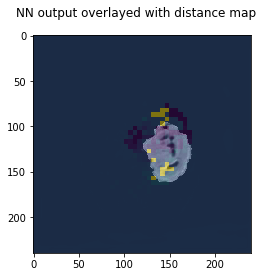

In [6]:
image = sample['input'].squeeze()[1]
scaled_distances = np.array(Image.fromarray(distances).resize(image.shape))
plt.imshow(output, cmap='gray')
plt.imshow(scaled_distances, cmap='viridis', alpha=0.5)
plt.suptitle('NN output overlayed with distance map')
plt.show()

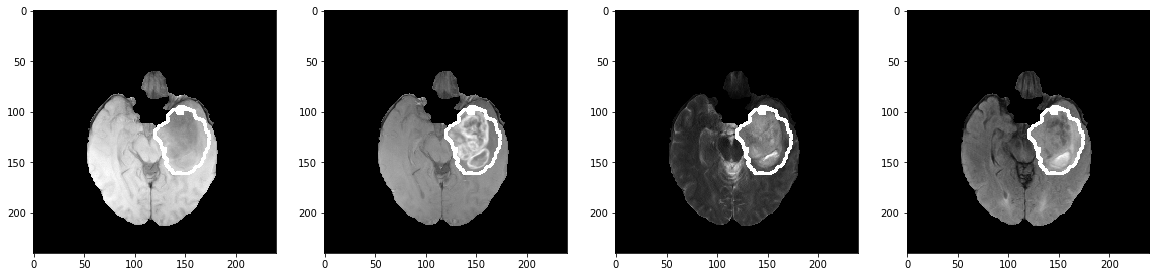

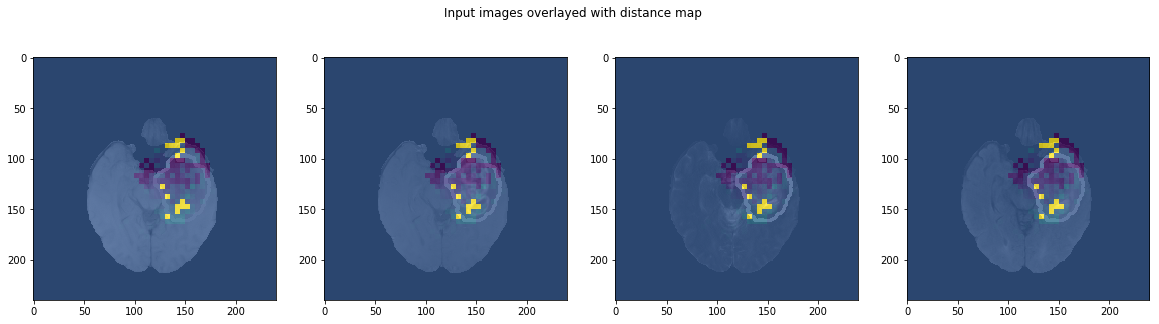

In [7]:
input_images = sample['input'].squeeze()
plot_image_row([input_images[0], input_images[1], input_images[2], input_images[3]], color_map='gray')
_, plots = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    plots[i].imshow(input_images[i], cmap='gray')
    plots[i].imshow(scaled_distances, cmap='viridis', alpha=0.8)
plt.suptitle('Input images overlayed with distance map')
plt.show()